In [1]:
%config Completer.use_jedi = False
%matplotlib notebook
import astropy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits
from glob import glob
import os
from tqdm import tqdm_notebook, tnrange, tqdm
#import pandas as pd
from astropy.wcs import WCS
import sys
from spectral_cube import SpectralCube
import fs
import fs.copy
import socket
import warnings

# Table of contents

[Read in data](#data)

[Produce cutouts](#cutouts)

[Get sizes of cutouts](#sizes)

[Write to files](#Write)

[Catalogue setup](#cat)

[- MongoDB](#mongo)

[-- Spherical lookups](#sphere)

[- SQL](#sql)

# Read in data
<a id='data'></a>

In [2]:
sbid = 8585
field = 'RACS_test4_1.05_1049-31A'

# Check host and get file locations
host = socket.gethostname()

print('Host is',host)

if host == 'motley':
    rootdir= '/data/motley/athomson/cubes'
    warnings.warn("Data is on remote disk. Read/Write will be slow.")
    
if host[:6] == 'galaxy' or host[:4] == 'zeus':
    rootdir = '/group/askap/mcc381/RACS'
    warnings.warn("Data is on remote disk. Read/Write will be slow.")

if host[:6] == 'avatar':
    rootdir = '/avatar/athomson/cubes'

Host is avatar29


In [3]:
# Glob out the necessary files
cubes = glob(f'{rootdir}/{sbid}/{field}/image.restored.*contcube*linmos*fits') # Data cubes
#selavyfits = glob(f'{rootdir}/{sbid}/{field}/*.fits') # Selavy images
#voisle = glob(f'{rootdir}/{sbid}/{field}/*island*.xml') # Selvay VOTab
#vocomp = glob(f'{rootdir}/{sbid}/{field}/*components*.xml') # Selvay VOTab
#vores = glob(f'{rootdir}/{sbid}/{field}/*results*.xml') # Selvay VOTab


selavyfits = glob(f'{rootdir}/{sbid}/{field}/selavy*/comp*.fits') # Selavy images
voisle = glob(f'{rootdir}/{sbid}/{field}/selavy*/*island*.xml') # Selvay VOTab
vocomp = glob(f'{rootdir}/{sbid}/{field}/selavy*/*components*.xml') # Selvay VOTab
vores = glob(f'{rootdir}/{sbid}/{field}/selavy*/*results*.xml') # Selvay VOTab

print('Getting source-fiding results from:', voisle,'\n')
print('Getting spectral data from:', cubes, '\n')
print('Getting source location data from:', selavyfits, '\n')

# Get selvay data from VOTab
islands = Table.read(voisle[0], format='votable') 
components = Table.read(vocomp[0], format='votable') 
#selres = Table.read(vores[0], format='votable') 

Getting source-fiding results from: ['/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy-cont-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored/selavy-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.islands.xml'] 

Getting spectral data from: ['/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.i.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.q.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.u.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits'] 

Getting source location data from: ['/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy-cont-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored/componentMap_image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy-co

In [49]:
test = components[components['col_has_siblings']==0]

In [50]:
test.add_index('col_island_id')

In [51]:
test.loc['SB8583_RACS_test4_1.05_1049-31A_island_1000']

col_island_id,col_component_id,col_component_name,col_ra_hms_cont,col_dec_dms_cont,col_ra_deg_cont,col_dec_deg_cont,col_ra_err,col_dec_err,col_freq,col_flux_peak,col_flux_peak_err,col_flux_int,col_flux_int_err,col_maj_axis,col_min_axis,col_pos_ang,col_maj_axis_err,col_min_axis_err,col_pos_ang_err,col_maj_axis_deconv,col_min_axis_deconv,col_pos_ang_deconv,col_maj_axis_deconv_err,col_min_axis_deconv_err,col_pos_ang_deconv_err,col_chi_squared_fit,col_rms_fit_gauss,col_spectral_index,col_spectral_curvature,col_spectral_index_err,col_spectral_curvature_err,col_rms_image,col_has_siblings,col_fit_is_estimate,col_spectral_index_from_TT,col_flag_c4,col_comment
--,--,,,,deg,deg,arcsec,arcsec,MHz,mJy/beam,mJy/beam,mJy,mJy,arcsec,arcsec,deg,arcsec,arcsec,deg,arcsec,arcsec,deg,arcsec,arcsec,deg,--,mJy/beam,--,--,--,--,mJy/beam,,,,,
bytes44,bytes48,bytes26,bytes12,bytes13,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,bytes100
SB8583_RACS_test4_1.05_1049-31A_island_1000,SB8583_RACS_test4_1.05_1049-31A_component_1000a,J104306-304254,10:43:06.3,-30:42:54,160.776168,-30.715169,0.05,0.06,887.5,11.895,0.081,21.413,0.185,19.81,16.01,169.07,0.14,0.02,1.32,15.34,5.74,11.71,0.02,0.17,0.63,284.963,1302.385,-1.06,-99.00,0.00,0.00,0.227,0,0,1,0,


In [53]:
for island_id in test['col_island_id']:
    print(test.loc[island_id]['col_flux_peak'])

11.895
11.641
11.308
11.682
11.766
11.759
11.656
10.004
11.772
11.82
11.449
11.487
11.661
110.418
11.441
11.224
11.538
11.421
11.563
11.668
11.311
11.412
107.618
11.724
11.542
11.671
10.779
11.166
11.476
11.441
11.664
11.417
11.653
106.807
11.479
10.094
11.129
10.607
11.243
11.384
11.115
11.349
11.23
11.482
11.073
11.165
11.191
10.797
11.224
11.265
10.377
107.153
10.884
11.084
10.641
11.009
10.932
10.966
10.841
10.877
11.08
10.53
10.848
10.735
10.972
10.925
10.969
10.69
10.454
10.951
10.673
10.601
9.984
10.77
10.56
10.075
10.832
10.583
10.147
10.671
10.069
10.6
10.574
10.664
10.422
10.35
10.334
10.756
103.013
708.449
10.65
10.406
10.524
9.409
10.51
10.535
10.447
10.445
102.166
10.376
9.488
10.388
9.822
10.504
10.359
10.432
10.008
10.53
87.093
8.339
10.506
9.701
10.489
10.46
10.453
9.727
10.278
10.263
9.896
100.248
10.207
10.223
10.097
10.575
10.166
9.842
10.243
10.115
10.43
98.775
10.39
10.062
10.157
9.131
10.039
10.099
10.057
10.173
10.05
10.162
9.981
9.902
10.074
9.866
9.343
9.651
9.

3.8
3.747
3.78
3.62
3.804
3.813
3.706
3.836
3.782
3.819
3.747
3.797
3.72
3.703
51.523
3.335
3.732
3.74
3.778
3.798
3.785
3.789
3.672
3.792
52.54
3.681
3.673
3.633
3.701
3.656
3.725
3.679
3.6
3.59
3.701
51.279
3.741
3.714
3.747
3.573
3.755
3.714
3.537
3.679
3.684
3.575
51.193
3.632
3.611
3.703
3.669
3.218
3.707
3.716
3.706
3.627
3.642
52.122
3.54
3.633
3.734
3.632
3.69
3.422
3.629
50.763
326.19
3.752
3.597
3.408
3.614
3.746
3.575
3.64
3.505
3.335
3.652
3.551
3.648
3.575
3.535
3.579
3.688
3.19
3.21
3.647
3.605
3.6
3.604
3.729
3.636
3.551
3.578
3.399
51.695
3.527
3.639
3.47
3.781
3.368
3.651
3.497
3.143
3.573
51.637
3.648
3.097
2.959
3.576
3.585
3.511
3.554
3.414
3.606
3.471
3.505
3.526
3.584
3.543
3.644
3.61
3.504
3.498
3.492
49.486
3.519
3.495
3.578
3.494
3.471
3.516
3.362
3.324
3.43
50.628
2.997
2.847
3.508
3.524
3.445
3.557
3.482
3.478
3.564
3.47
51.114
3.337
3.557
3.294
3.372
3.38
2.958
3.484
3.446
3.446
2.851
3.493
3.475
3.471
3.27
3.509
3.459
3.452
3.477
3.428
318.392
2.812
3.448
3

2.039
1.99
1.882
1.962
1.958
1.948
33.984
1.992
1.978
1.896
1.915
1.856
1.863
1.786
1.961
1.873
1.943
35.292
1.577
1.882
1.929
1.856
1.919
1.94
1.932
1.947
1.915
34.183
1.946
1.92
1.851
1.93
1.791
1.9
1.958
1.904
1.849
1.905
1.939
1.915
1.913
1.941
1.918
1.951
1.86
1.886
33.639
1.898
1.862
1.896
1.753
1.872
1.954
1.818
1.941
1.931
1.761
1.923
1.891
1.891
1.88
1.899
1.915
1.885
1.888
1.929
33.508
1.913
1.88
1.84
1.882
1.867
1.889
1.86
1.904
1.871
1.888
33.738
234.22
1.833
1.896
1.86
1.875
1.88
1.903
1.865
1.861
1.868
1.883
1.869
1.502
1.907
1.855
1.861
1.816
1.882
1.86
1.892
1.673
1.842
1.815
1.869
1.88
1.853
1.901
1.901
1.903
1.832
1.845
1.829
1.87
1.855
1.879
1.85
1.871
1.888
33.165
1.847
1.845
1.86
1.846
1.823
1.861
1.788
1.86
1.833
1.835
33.237
1.762
1.855
1.783
1.825
1.849
1.789
1.857
1.871
1.816
32.843
1.823
1.848
1.823
1.817
1.869
1.794
1.866
1.611
1.773
1.826
1.8
1.839
1.837
1.745
1.83
1.829
1.801
1.772
1.853
1.818
1.848
1.788
1.841
1.843
1.836
1.787
32.752
1.568
1.857
1.79
1.80

1.065
1.01
1.1
1.105
24.768
1.097
1.075
1.098
1.088
1.101
1.086
1.061
1.08
1.097
1.098
25.101
1.073
1.075
1.133
1.038
1.057
1.074
1.067
1.048
1.068
1.061
25.384
1.074
1.058
1.054
1.067
1.058
1.049
0.926
1.085
1.067
1.043
24.478
1.04
1.064
1.066
1.044
1.055
1.083
1.048
1.075
1.043
24.706
1.052
1.057
1.06
1.051
1.029
1.038
1.056
1.049
1.03
24.69
1.039
1.054
0.961
1.02
1.02
1.036
1.019
1.037
1.036
1.012
24.028
1.023
1.021
1.049
1.032
0.983
1.015
1.014
1.017
1.008
1.034
24.36
0.99
1.008
1.018
1.013
1.002
1.007
0.995
1.014
0.992
1.011
24.083
0.979
1.029
1.001
0.982
1.014
1.004
0.981
0.892
0.958
0.965
25.046
0.946
0.915
24.089
24.303
24.096
24.886
24.508
24.234
180.049
24.536
24.142
24.001
24.331
22.342
24.073
23.802
24.406
24.18
175.512
24.151
23.593
23.738
23.563
20.784
23.496
23.317
23.637
22.889
173.101
23.119
23.076
22.98
23.057
22.793
22.896
23.125
22.286
171.658
22.991
22.6
22.676
24.464
22.336
22.679
22.512
21.535
22.467
22.39
170.711
22.638
22.154
21.967
22.058
22.603
22.1
21.485
21

In [5]:
# Read data using Spectral cube
i_taylor = SpectralCube.read(selavyfits[0], mode='denywrite')
wcs_taylor = WCS(i_taylor.header)
i_cube = SpectralCube.read(cubes[0], mode='denywrite')
wcs_cube = WCS(i_cube.header)
q_cube = SpectralCube.read(cubes[1], mode='denywrite')
u_cube = SpectralCube.read(cubes[2], mode='denywrite')

In [6]:
q_cube.shape

(288, 8720, 8719)

Source finding was done on full field, but cubes are only 16 beam. So we need to convert from image pixel locations to WCS to cube pixel locations

In [7]:
# Get bounding boxes in WCS
ra_min, dec_min, freq = wcs_taylor.all_pix2world(islands['col_x_min'], islands['col_y_min'], 0, 0)
ra_max, dec_max, freq = wcs_taylor.all_pix2world(islands['col_x_max'], islands['col_y_max'], 0, 0)

# Get bounding boxes in cube pixels
x_min, y_min, _ = np.array(wcs_cube.all_world2pix(ra_min, dec_min, freq, 0)).astype(int)
x_max, y_max, _ = np.array(wcs_cube.all_world2pix(ra_max, dec_max, freq, 0)).astype(int)
dy, dx = y_max - y_min, x_max-x_min

# Produce cutouts
<a id='cutouts'></a>

In [8]:
# Init cutouts
i_cutouts = []
q_cutouts = []
u_cutouts = []
outdir = f'{rootdir}/{sbid}/{field}/cutouts_python/'
source_dict_list = []

try:
    os.mkdir(outdir)
except:
    print('Directory exists')

Directory exists


In [9]:
pad = 0.5 # Chose pad fraction of bounding box around source
# TO-DO: Max cut on size
for i in tnrange(len(islands)):
    source_dict = {}
    # Skip if source is outside of cube bounds
    if y_max[i]>i_cube.shape[2] or x_max[i]>i_cube.shape[2] or x_min[i]<0 or y_min[i]<0:
        continue
    # Check if pad puts bbox outside of cube
    elif int(y_min[i]-pad*dy[i]) > 0 and int(x_min[i]-pad*dx[i]) > 0 and \
        int(y_max[i]+pad*dy[i]) < i_cube.shape[2] and int(x_max[i]+pad*dx[i]) < i_cube.shape[2]:
        i_cutout = i_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        q_cutout = q_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        u_cutout = u_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        
        i_cutout.meta['OBJECT'] = islands['col_island_name'][i]
        q_cutout.meta['OBJECT'] = islands['col_island_name'][i]
        u_cutout.meta['OBJECT'] = islands['col_island_name'][i]
        i_cutouts.append(i_cutout)
        q_cutouts.append(q_cutout)
        u_cutouts.append(u_cutout)
        
        source_dict['header'] = i_cutout.header
        for name in islands.colnames:
            source_dict[name.replace('col_', '')] = islands[name][i]
        source_dict_list.append(source_dict)
    else:
        i_cutout = i_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        q_cutout = q_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        u_cutout = u_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        i_cutout.meta['OBJECT'] = islands['col_island_name'][i]
        q_cutout.meta['OBJECT'] = islands['col_island_name'][i]
        u_cutout.meta['OBJECT'] = islands['col_island_name'][i]
        i_cutouts.append(i_cutout)
        q_cutouts.append(q_cutout)
        u_cutouts.append(u_cutout)
        
        source_dict['header'] = i_cutout.header
        for name in islands.colnames:
            source_dict[name.replace('col_', '')] = islands[name][i]
        source_dict_list.append(source_dict)

In [10]:
# Set up locations where files will be saved
for i in tnrange(len(source_dict_list)):
    for stoke in ['i','q','u']:
        name = source_dict_list[i]['island_name']
        #outname = f'{outdir}image.restored.{stoke}.SB.{sbid}.contcube.{field}.cutout.{name}.fits'
        outname = f'{outdir}{name}.cutout.{stoke}.fits'
        source_dict_list[i][f'{stoke}_file'] = outname

## Get sizes of cutouts
<a id='sizes'></a>

In [11]:
sizes_bytes = []
for i in tnrange(len(i_cutouts)):
    sizes_bytes.append(i_cutouts[i][0,:,:].nbytes*i_cutouts[i].shape[0]*1e-6)
    
sizes_bytes = np.array(sizes_bytes)


In [12]:
print('Size in MB: ',sizes_bytes.sum())
print('Size in GB: ',sizes_bytes.sum()/1000)

Size in MB:  1884.753792
Size in GB:  1.884753792


# Write to files
<a id='Write'></a>

***

### Mem_FS tests
_No longer needed_

_Used for testing bottlenecks_

Testing with a memory filesystem. This _should_ be the fastest possible write.

In [ ]:
with mem_fs as MemoryFS():
    mem_fs.makedirs('cutouts')
    for i in tnrange(len(i_cutouts)):
        outname_mem = f'cutouts/image.restored.{stoke}.SB.{sbid}.contcube.{field}.cutout.{name}.fits'
        with mem_fs.open(outname_mem, 'wb') as fitsfile:
            i_cutouts[i].write(fitsfile, overwrite=True, format='fits')
    for path in mem_fs.walk.files(path='cutouts'):
        print(path)

***

### Write to disk

In [82]:
def writefits(arg):
    """Write cutouts to disk.

    Writes a cutout, as stored in source_dict, to disk. The file location
    should already be specified in source_dict. This format is intended 
    for parallel use with pool.map syntax.

    Args:
        arg: The tuple of (i, stoke)
            i: The index of the source in source_dict to write to disk.
            stoke: Which Stokes to write. Is a string of either 'i', 
                'q', or 'u'.
    """
    i, stoke = arg
    outfile = source_dict_list[i][f'{stoke}_file']
    if stoke=='i':
        i_cutouts[i].write(outfile, format='fits', overwrite=True)
    if stoke=='q':
        q_cutouts[i].write(outfile, format='fits', overwrite=True)
    if stoke=='u':
        u_cutouts[i].write(outfile, format='fits', overwrite=True)

In [83]:
import schwimmbad
from multiprocessing import cpu_count

In [84]:
n_cores = cpu_count() # Use all available cores
use_mpi = False # Use or not with Schwimmbad

In [85]:
# Use Schwimmbad to write all cutouts to disk in parallel
with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
    for stoke in ['i','q','u']:
        if use_mpi:
            pool.map(writefits, [[i, stoke] for i in range(len(i_cutouts))])
        else:
            r=list(tqdm_notebook(pool.imap_unordered(writefits, 
                                              [[i, stoke] for i in range(len(i_cutouts))]),
                         total = len(i_cutouts)
                         ))

# Catalogue setup
<a id='cat'></a>

Currently the data is passed from a dictionary, to a dataclass, and then to JSON format. This works with a MongoDB approach.

To-do: Format the data for SQL formatting. Or, possibly just a VOTable. Whatever ends up being the best.

In [12]:
from dataclasses import dataclass, asdict, make_dataclass
import dataclasses
from astropy.coordinates import SkyCoord
from astropy.io.fits import Header
import astropy.units as u
import json


In [13]:
print(source_dict_list[0].keys())

dict_keys(['header', 'island_id', 'island_name', 'n_components', 'ra_hms_cont', 'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'freq', 'maj_axis', 'min_axis', 'pos_ang', 'flux_int', 'flux_int_err', 'flux_peak', 'mean_background', 'background_noise', 'max_residual', 'min_residual', 'mean_residual', 'rms_residual', 'stdev_residual', 'x_min', 'x_max', 'y_min', 'y_max', 'n_pix', 'solid_angle', 'beam_area', 'x_ave', 'y_ave', 'x_cen', 'y_cen', 'x_peak', 'y_peak', 'flag_i1', 'flag_i2', 'flag_i3', 'flag_i4', 'comment', 'i_file', 'q_file', 'u_file'])


In [14]:
# Create a dataclass with source_dict keys at attributes
cube_class = make_dataclass('cube_class',
                            [(key, type(source_dict_list[0][key])) for key in source_dict_list[0].keys()]
                             )

In [15]:
def head2dict(h):
    """Convert FITS header to a dict.

    Writes a cutout, as stored in source_dict, to disk. The file location
    should already be specified in source_dict. This format is intended 
    for parallel use with pool.map syntax.

    Args:
        h: An astropy FITS header.
     
    Returns:
        data: The FITS head converted to a dict.
    """
    data = {}
    for i, c in enumerate(h.__dict__['_cards']):
        if c[0] == '': continue
        data[c[0]] = c[1]
    return(data)

In [16]:
class MyEncoder(json.JSONEncoder):
    """Cutom JSON encorder.
    
    Parses the data stored in source_dict to JSON without
    errors.
    """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, fits.Header):
            return head2dict(obj)
        elif dataclasses.is_dataclass(obj):
                return dataclasses.asdict(obj)
        else:
            return super(MyEncoder, self).default(obj)

### MongoDB
<a id='mongo'></a>
Requires `mongod` to be running in the background

In [17]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)

In [18]:
mydb = client['racs']  # Create/open database

In [21]:
mycol = mydb['spice']  # Create/open collection

In [20]:
mycol.drop() # Close collection

In [95]:
# Test with first cuout
json_data = json.loads(json.dumps(source_dict_list[0], cls=MyEncoder))
result = mycol.insert_one(json_data)
print(result.inserted_id)

5db7bc7fcf643509dec6ddef


In [96]:
# Quick check to confirm load
x = mycol.find_one()

x['q_file']

'/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/cutouts_python/J110106-314027.cutout.q.fits'

In [56]:
source_dict_list[0]['q_file']

'/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/cutouts_python/J110106-314027.cutout.q.fits'

In [22]:
# Load all into database
for source_dict in tqdm_notebook(source_dict_list):
    json_data = json.loads(json.dumps(source_dict, cls=MyEncoder))
    name = source_dict['island_name']
    count = mycol.count_documents({'island_name': name})

    if count > 0:
        # Replace existing
        cursor = mycol.find({'island_name': name})
        for doc in cursor:
            result = mycol.replace_one({'_id': doc['_id']}, json_data)
    else:
        # Insert new
        result = mycol.insert_one(json_data)

In [23]:
# Check if all cutouts are in collection
count = mycol.count_documents({})
print('Total documents:', count)

Total documents: 3843


In [69]:
# Basic querey
myquery = { "n_components": { "$lt": 2 } }

#mydoc = mycol.find(myquery, { "_id": 0, "island_name": 1, "flux_int": 1 , "n_components": 1})
mydoc = mycol.find(myquery).sort("flux_int", -1)

#for x in mydoc:
#    print(x)

<IPython.core.display.Javascript object>


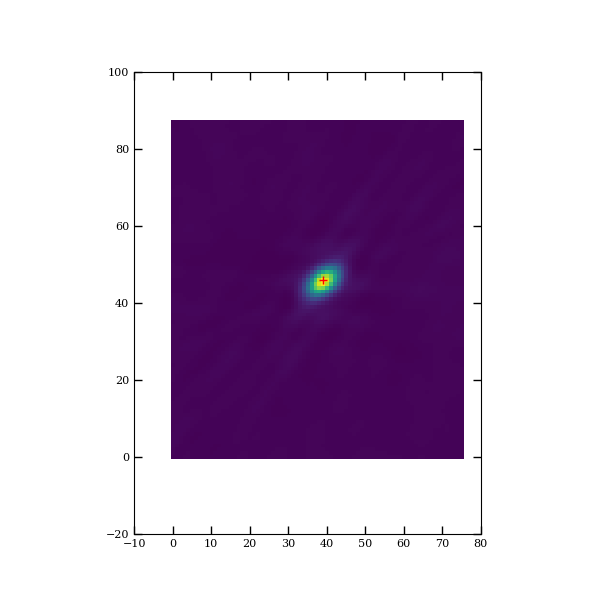

(46, 39)


<IPython.core.display.Javascript object>


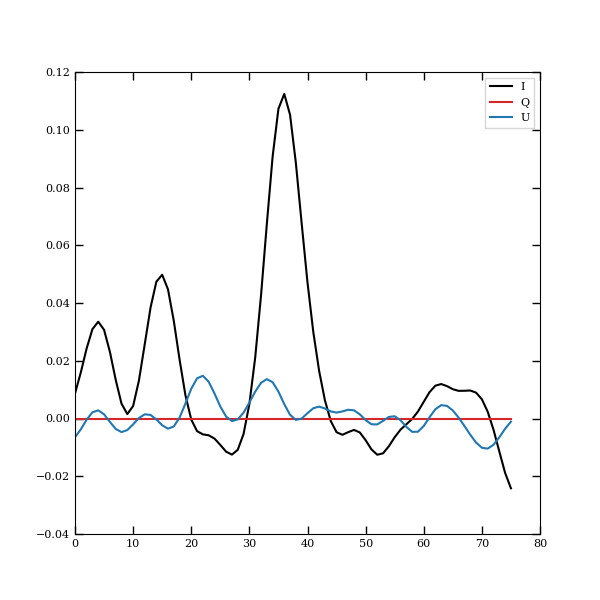

<IPython.core.display.Javascript object>


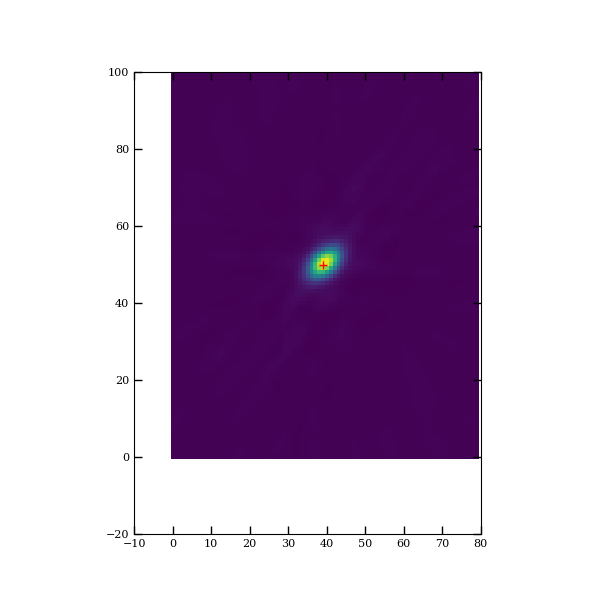

(50, 39)


<IPython.core.display.Javascript object>


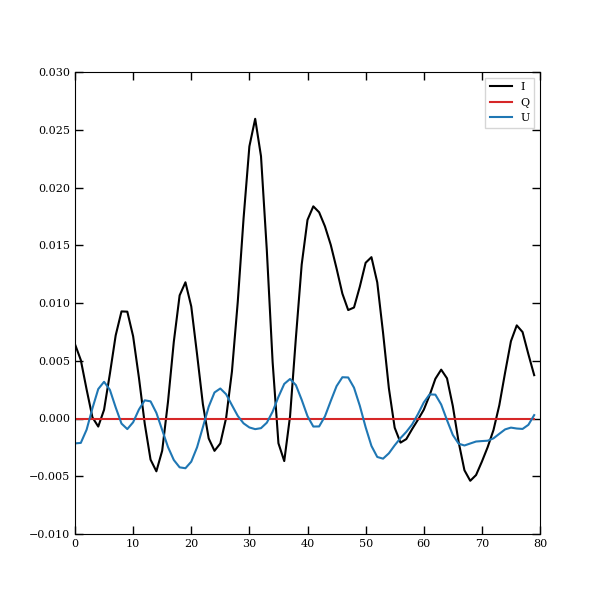

<IPython.core.display.Javascript object>


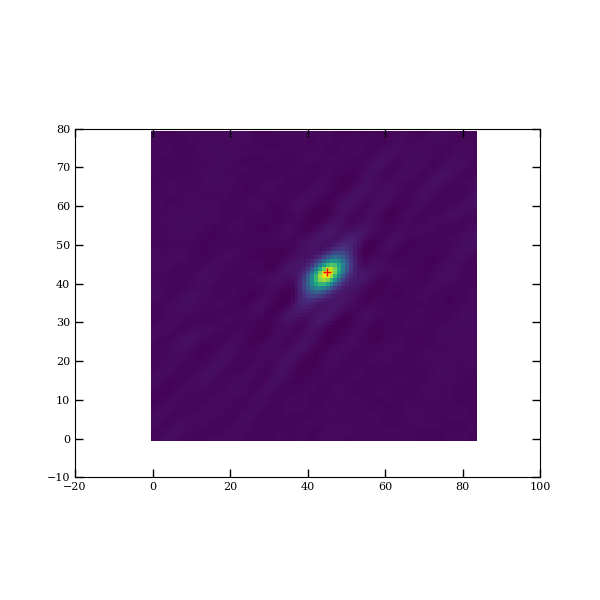

(43, 45)


<IPython.core.display.Javascript object>


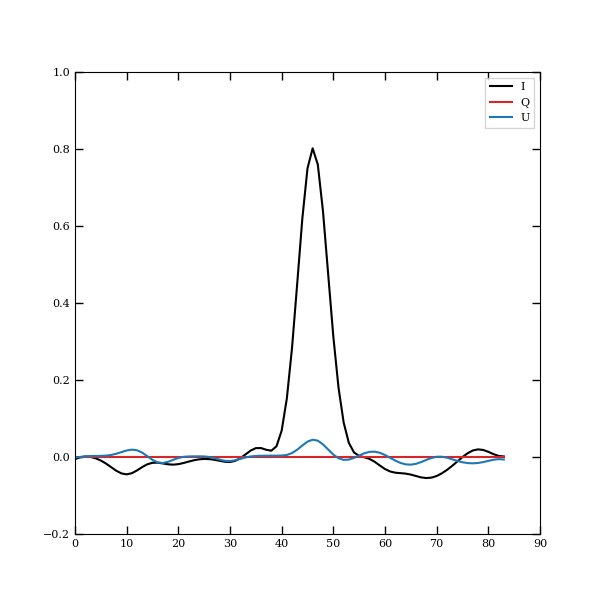

<IPython.core.display.Javascript object>


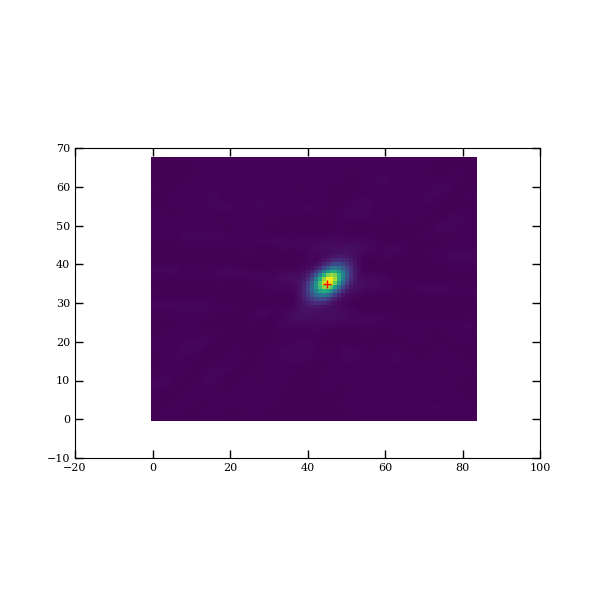

(35, 45)


<IPython.core.display.Javascript object>


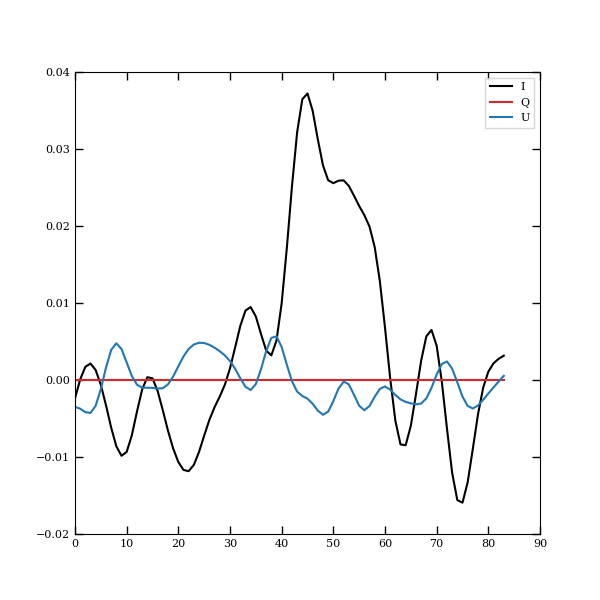

<IPython.core.display.Javascript object>


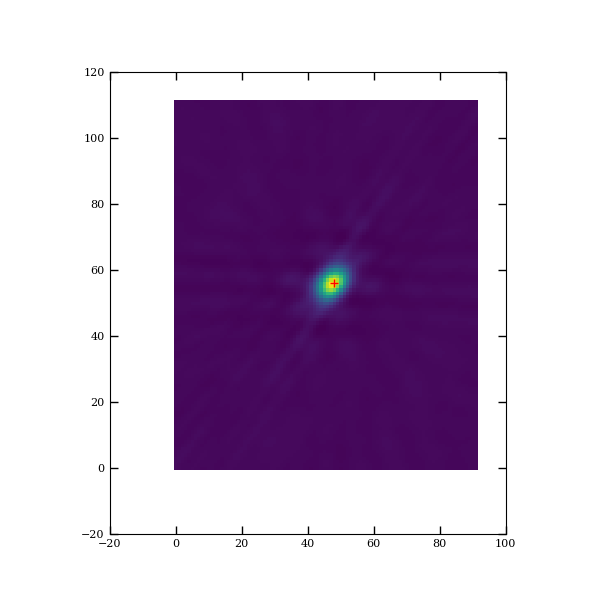

(56, 48)


<IPython.core.display.Javascript object>


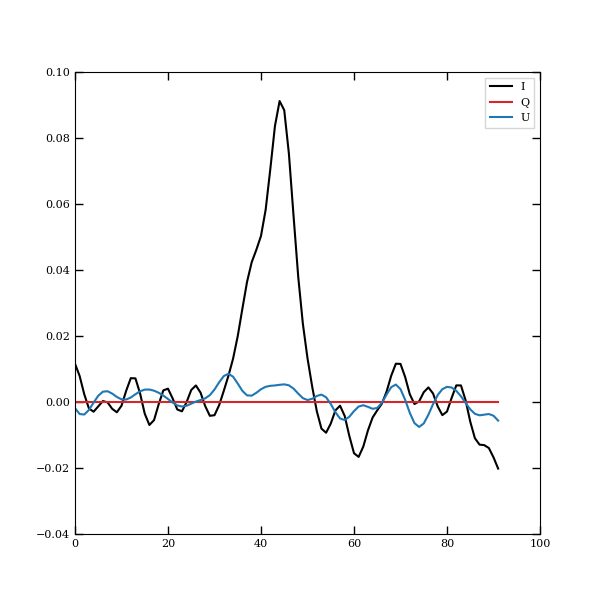

In [89]:
for i in range(5):
    with fits.open(mydoc[i]["i_file"], memmap=True, mode='denywrite') as hdulist:
        hdu = hdulist[0]
        testdata = hdu.data
        im_av = np.nanmean(testdata, axis=0)
        peak = np.argmax(im_av)
        plt.figure()
        plt.imshow(im_av, origin='lower')
        ind = np.unravel_index(np.argmax(im_av, axis=None), im_av.shape)
        print(ind)
        plt.plot(ind[1],ind[0], 'r+')
        with fits.open(mydoc[i]["q_file"], memmap=True, mode='denywrite') as qlist:
            with fits.open(mydoc[i]["u_file"], memmap=True, mode='denywrite') as ulist:
                qdu = qlist[0]
                qdata = qdu.data
                udu = ulist[0]
                udata = udu.data
                plt.figure()
                plt.plot(testdata[ind], 'k', label='I')
                plt.plot(qdata[ind], 'tab:red', label='Q')
                plt.plot(udata[ind], 'tab:blue', label='U')
                plt.legend()

#### Spherical lookups
<a id='sphere'></a>

Following [this](http://strakul.blogspot.com/2019/07/data-science-mongodb-sky-searches-with.html) tutorial to use MongoDB spherical queries for astro.

In [321]:
# Remove any existing coords.loc field
mycol.update_many({}, {'$unset': {'coords.loc': ''}}) 

# Loop over those without coords.healpix and set the value
cursor = mycol.find({'coords.loc': {'$exists': False}})
for doc in tqdm_notebook(cursor):
    # RA must have values between -180 and 180
    geojson = { 'type': "Point", 'coordinates': [ doc['ra_deg_cont']-180., doc['dec_deg_cont'] ] }
    #print(doc['island_name'], doc['ra_deg_cont'], doc['ra_deg_cont'], geojson)
    mycol.update_one({'_id': doc['_id']}, {'$set': {'coords.loc': geojson}})

In [322]:
if 'geosphere' not in mycol.index_information():
    mycol.create_index([('coords.loc', pymongo.GEOSPHERE)],
                          name='geosphere', background=True)

In [323]:
def wgs_scale(lat):
    # Get scaling to convert degrees to meters at a given geodetic latitude (declination)
    
    # Values from WGS 84
    a = 6378137.000000000000 # Semi-major axis of Earth
    b = 6356752.314140000000 # Semi-minor axis of Earth
    e = 0.081819190842600 # eccentricity
    angle = np.radians(1.0)
    
    # Compute radius of curvature along meridian (see https://en.wikipedia.org/wiki/Meridian_arc)
    rm = a * (1 - np.power(e, 2)) / np.power( ( (1 - np.power(e, 2) * np.power( np.sin(np.radians(lat)), 2) ) ), 1.5)
    
    # Compute length of arc at this latitude (meters/degree)
    arc = rm * angle
    return arc

In [324]:
def cone_search(ra, dec, radius, collection=mycol, field='coords.loc'):
    """Perform a cone search using MongoDB.

    Copyright (c) 2019 David R. Rodriguez.
    
    Perform a cone-search query of a MongoDB collection. All inputs are given
    in decimal degrees.

    Args:
        ra: Right ascension of cone centre.
        dec: Declination of cone centre.
        radius: Radius of search cone.
        
    Kwargs:
        collection: Mongo collection to query.
        field: Which field in the collection to query.
        
    Returns:
        cursor: Mongo cursor containing matching entires.
    """
    scaling = wgs_scale(dec)
    meter_radius = radius * scaling
    lon, lat = ra-180., dec
    
    cursor = collection.find({field: {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': meter_radius
    } } })
    
    return cursor

In [353]:
import pprint

In [359]:
# Test cone search
cursor = cone_search(165., -30., 0.1)
for doc in cursor:
    pprint.pprint(doc,indent=2)

{ '_id': ObjectId('5d89b309f91aee8485757db9'),
  'background_noise': 0.3149999976158142,
  'beam_area': 0.03999999910593033,
  'comment': '',
  'coords': {'loc': {'coordinates': [-14.923901, -30.004677], 'type': 'Point'}},
  'dec_deg_cont': -30.004677,
  'dec_dms_cont': '-30:00:16',
  'flag_i1': 0,
  'flag_i2': 0,
  'flag_i3': 0,
  'flag_i4': 0,
  'flux_int': 0.16899999976158142,
  'flux_int_err': 0.0,
  'flux_peak': 3.319000005722046,
  'freq': 887.5,
  'header': { 'ALTRPIX': 1.0,
              'ALTRVAL': 272562691.5565,
              'BEAM': 'Beam: BMAJ=17.955658518001847 arcsec '
                      'BMIN=11.140361221160449 arcsec BPA=-51.9109619213644 '
                      'deg',
              'BITPIX': -32,
              'BMAJ': 0.00498768292166718,
              'BMIN': 0.00309454478365568,
              'BPA': -51.9109619213644,
              'BSCALE': 1.0,
              'BTYPE': 'Intensity',
              'BUNIT': 'beam-1 Jy',
              'BZERO': 0.0,
              'CDEL

In [338]:
%matplotlib inline

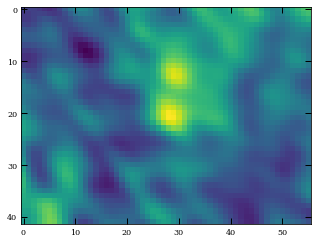

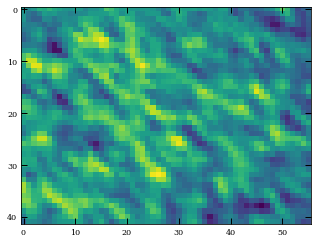

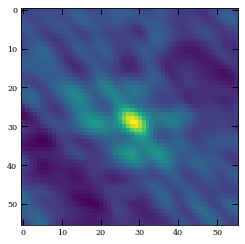

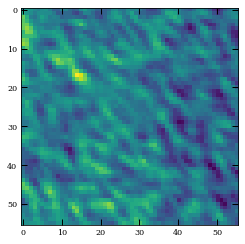

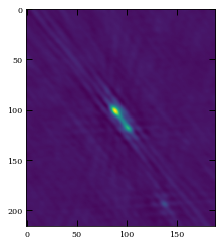

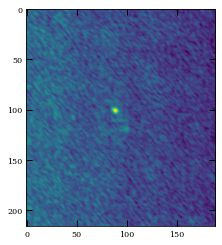

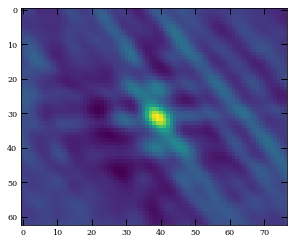

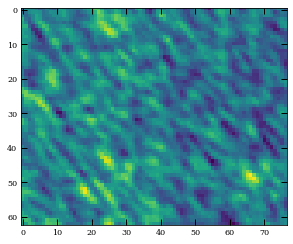

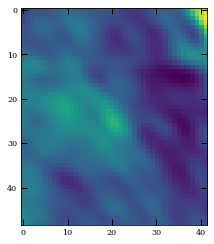

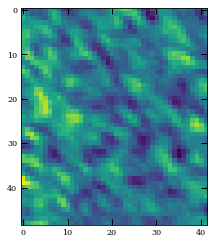

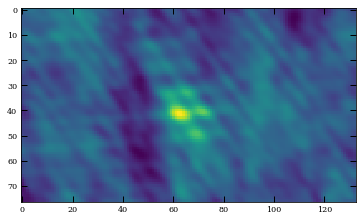

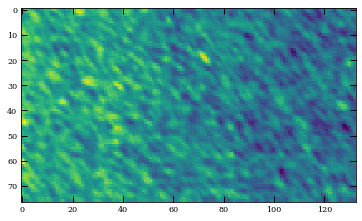

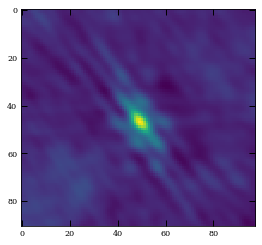

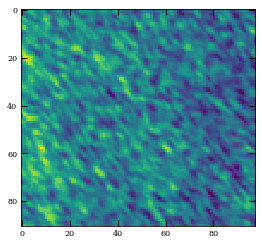

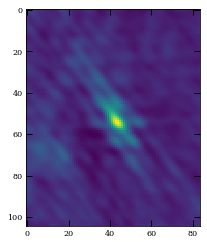

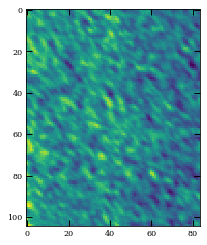

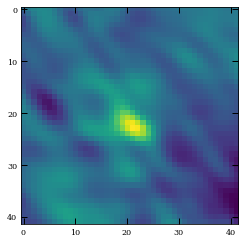

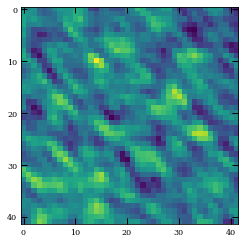

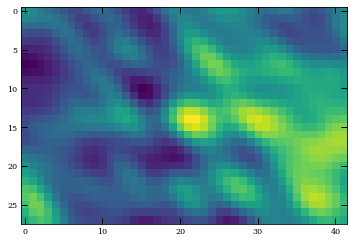

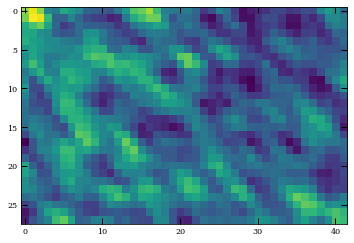

In [350]:
# Test consource and make plots of data
cursor = cone_search(165., -30., 0.2)
for doc in cursor:
    temp_file = doc['i_file']
    cube_temp = SpectralCube.read(temp_file)
    plt.figure()
    cube_temp.moment0(axis=0).quicklook(use_aplpy=False)
    
    temp_q_file = doc['q_file']
    cube_q_temp = SpectralCube.read(temp_q_file)
    temp_u_file = doc['u_file']
    cube_u_temp = SpectralCube.read(temp_u_file)
    cube_p_temp = (cube_q_temp**2 + cube_u_temp**2)**0.5
    plt.figure()
    cube_p_temp.moment0(axis=0).quicklook(use_aplpy=False)
    #fig.figsize(2,2)

### SQL
<a id='sql'></a>

Under construction...

In [2]:
import mysql.connector as mysql

In [8]:
import mysql.connector
from mysql.connector import errorcode

try:
    cnx = mysql.connector.connect(user='athomson')
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cnx.close()

2003 (HY000): Can't connect to MySQL server on '127.0.0.1' (111)


In [114]:
import sqlite3

In [122]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn


def create_project(conn, project):
    """
    Create a new project into the projects table
    :param conn:
    :param project:
    :return: project id
    """
    sql = ''' INSERT INTO projects(name,begin_date,end_date)
              VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, project)
    return cur.lastrowid


def create_task(conn, task):
    """
    Create a new task
    :param conn:
    :param task:
    :return:
    """

    sql = ''' INSERT INTO tasks(name,priority,status_id,project_id,begin_date,end_date)
              VALUES(?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, task)
    return cur.lastrowid

In [123]:
database = ":memory:"

# create a database connection
conn = create_connection(database)
with conn:
    # create a new project
    project = ('Cool App with SQLite & Python', '2015-01-01', '2015-01-30');
    project_id = create_project(conn, project)

    # tasks
    task_1 = ('Analyze the requirements of the app', 1, 1, project_id, '2015-01-01', '2015-01-02')
    task_2 = ('Confirm with user about the top requirements', 1, 1, project_id, '2015-01-03', '2015-01-05')

    # create tasks
    create_task(conn, task_1)
    create_task(conn, task_2)

OperationalError: no such table: projects

In [119]:
conn